In [1]:
%cd '/home/aris/projects/GraB'

%load_ext autoreload
%autoreload 1

from IPython.display import display

/home/aris/projects/GraB


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
import pickle
import time
from tqdm.notebook import tqdm

In [3]:
def show_df(df: pd.DataFrame):
    display(df.head())
    print(df.shape)

In [4]:
def _herding_bound(vecs):
    return np.maximum.reduce(
        np.linalg.norm(np.cumsum(vecs, axis=0), ord=np.inf, axis=1)
    )


def herding_bound(vecs: torch.Tensor):
    return torch.amax(
        torch.norm(torch.cumsum(vecs, dim=0), p=torch.inf, dim=1)
    )


a = np.random.random((16, 32))
print(_herding_bound(a))
print(herding_bound(torch.tensor(a)))

10.24950514337683
tensor(10.2495, dtype=torch.float64)


In [5]:
from torchvision import datasets, transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

# Loading the dataset and preprocessing
train_dataset = datasets.CIFAR10(
    root='data/external',
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
)
train_eval_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=16
)

In [48]:
import torch.nn.functional as F
from experiments.models import LeNet
from torch.func import functional_call, grad, vmap


def compute_loss(params, inputs, targets):
    logits = functional_call(model, (params, buffers), (inputs,))
    return F.cross_entropy(logits, targets)


path = Path('checkpoints/cifar10-lenet/mean')
model = LeNet().cuda()

for p in model.parameters():
    p.requires_grad = False

params = dict(model.named_parameters())
buffers = dict(model.named_buffers())

func = vmap(grad(compute_loss), in_dims=(None, 0, 0))

for epoch in range(10):
    file_name = f'cifar10_lenet_mean_sgd_lr_0.001_wd_0.01_b_16_seed_42_epoch_{epoch}.pt'
    model.load_state_dict(torch.load(path / file_name))

    norms = []

    for x, y in tqdm(
            train_eval_loader, total=len(train_eval_loader),
            leave=False
    ):
        x = x.cuda()
        y = y.cuda()

        pred = model(x)

        grads = func(params, x, y)

        grads = torch.cat([
            g.view(16, -1)
            for g in grads.values()
        ], dim=1)
        # print(grads.shape)

        norms.extend(torch.norm(grads, dim=1).tolist())
    print(f'Epoch {epoch} norm mean {np.mean(norms)}'
          f'std {np.std(norms)} max: {np.max(norms)} min: {np.min(norms)}')

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 0 norm mean 17.69161908040762std 8.563230446463175 max: 77.49795532226562 min: 1.854677677154541


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 norm mean 20.679856199375987std 11.072793940909309 max: 100.25169372558594 min: 0.30779364705085754


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2 norm mean 22.526784385383426std 12.727875534775718 max: 106.14271545410156 min: 0.13433608412742615


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3 norm mean 23.967497034246026std 14.716304090732761 max: 108.36014556884766 min: 0.09058291465044022


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4 norm mean 24.51688101641059std 15.763033817846347 max: 130.566650390625 min: 0.1146102026104927


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5 norm mean 24.95135305779055std 15.795965332404192 max: 110.46562194824219 min: 0.09368083626031876


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6 norm mean 25.667767227527797std 17.077090915038625 max: 129.92721557617188 min: 0.032602835446596146


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7 norm mean 26.107468663069607std 17.54887129462125 max: 129.4598388671875 min: 0.03416610136628151


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8 norm mean 25.779500192583242std 17.479771151535594 max: 122.93402862548828 min: 0.02552756853401661


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9 norm mean 25.55953122048868std 17.810643416030803 max: 123.98381042480469 min: 0.010283539071679115


In [39]:
miu, sigma = 27.7, 23
# n, d = 50_000, 62_000
n, d = 20000, 62_000

norms = torch.normal(miu, sigma, (n,))

In [6]:
def random_vector_with_2norm(_d, norm, dtype=torch.float16):
    # Generate Uniform Random Variates with Constant Norm
    # https://stats.stackexchange.com/a/487505
    # https://stats.stackexchange.com/a/487505
    v = torch.normal(0, 1, (_d,), dtype=dtype, device='cuda')
    v = v * norm / torch.norm(v)
    return v.to(dtype=dtype)

In [101]:
V = torch.stack([
    random_vector_with_2norm(d, e) for e in norms
]).to(dtype=torch.float16, device='cuda')

print(V.shape)
print(V.mean(dim=1))
print(V.norm(dim=1).mean())
print(V.norm(dim=1).std())

torch.Size([20000, 62000])
tensor([-1.4126e-05, -9.5367e-07, -1.4186e-05,  ..., -2.0862e-06,
        -1.8716e-05,  2.8729e-05], device='cuda:0', dtype=torch.float16)
tensor(0.7944, device='cuda:0', dtype=torch.float16)
tensor(0.6045, device='cuda:0', dtype=torch.float16)


In [102]:
bound = herding_bound(V)

print(bound)

tensor(2.4336, device='cuda:0', dtype=torch.float16)


In [7]:
# miu, sigma = 27.7, 23
miu, sigma = 0, 1
# n, d = 50_000, 62_000
# n, d = 10000, 62_000
n, d = 20000, 512

norms = torch.normal(miu, sigma, (n,))

V = torch.stack([
    random_vector_with_2norm(d, e) for e in norms
]).to(dtype=torch.float16, device='cuda')
print(V.mean(dim=0).shape)
print(V.mean(dim=0).sum())
print(V.mean(dim=1))
print(V.norm(dim=1).mean())
print(V.norm(dim=1).std())
print('-' * 50)
V = V - V.mean(dim=0)

print(V.mean(dim=0).shape)
print(V.mean(dim=0).sum())
print(V.mean(dim=1))
print(V.norm(dim=1).mean())
print(V.norm(dim=1).std())


def run_reordering_rr(n, d, epochs):
    bounds = []
    bounds.append(herding_bound(V).item())
    for epoch in range(epochs):
        orders = torch.randperm(n)
        bounds.append(herding_bound(V[orders]).item())

    return bounds


run_reordering_rr(n, d, 10)

torch.Size([512])
tensor(-0.0082, device='cuda:0', dtype=torch.float16)
tensor([-1.3561e-03, -1.3351e-03,  5.6624e-06,  ..., -4.3631e-04,
        -3.1796e-03, -3.8490e-03], device='cuda:0', dtype=torch.float16)
tensor(0.7939, device='cuda:0', dtype=torch.float16)
tensor(0.5986, device='cuda:0', dtype=torch.float16)
--------------------------------------------------
torch.Size([512])
tensor(-5.6028e-06, device='cuda:0', dtype=torch.float16)
tensor([-1.3399e-03, -1.3180e-03,  2.1636e-05,  ..., -4.2057e-04,
        -3.1643e-03, -3.8319e-03], device='cuda:0', dtype=torch.float16)
tensor(0.7939, device='cuda:0', dtype=torch.float16)
tensor(0.5986, device='cuda:0', dtype=torch.float16)


[10.96875,
 12.203125,
 12.1171875,
 11.609375,
 11.578125,
 11.2421875,
 11.4375,
 12.859375,
 11.3359375,
 11.3984375,
 10.546875]

In [2]:
from grabngo.sorter import *





n, d = 20000, 62000

run_reordering(n, d, 10, balance='mean')
run_reordering(n, d, 10, balance='mean', prob=True)

NameError: name 'V' is not defined

In [22]:

run_reordering(n, d, 5, balance='recursive')

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.31 GiB (GPU 0; 23.68 GiB total capacity; 20.85 GiB already allocated; 1.95 GiB free; 20.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

--------------------------------------------------
n 20000 d 62000 miu 27.7 sigma 23
rr done


KeyboardInterrupt: 

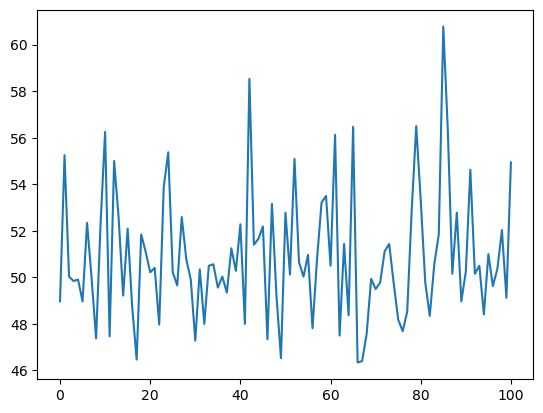

In [16]:
def get_vecs(n, d, miu, sigma, dtype=torch.float16):
    norms = torch.normal(miu, sigma, (n,))
    V = torch.stack([
        random_vector_with_2norm(d, e, dtype=dtype) for e in norms
    ]).to(dtype=dtype, device='cuda')
    return V - V.mean(dim=0)


miu, sigma = 27.7, 23
# for n in [1000, 5000, 10000, 20000]:
for n in [20000]:
    # for d in [128, 256, 1024]:
    for d in [62000]:
        print('-' * 50)
        print(f'n {n} d {d} miu {miu} sigma {sigma}')
        # V = get_vecs(n, d, miu, sigma, dtype=torch.float32)
        V = get_vecs(n, d, miu, sigma, dtype=torch.float16)
        # print(run_reordering_rr(n, d, 10))
        # print(run_reordering(n, d, 10, balance='mean'))
        # print(run_reordering(n, d, 10, balance='recursive'))
        plt.plot(range(101), run_reordering_rr(n, d, 100), label='rr')
        print('rr done')
        plt.plot(range(101), run_reordering(n, d, 100, balance='mean'),
                 label='mean')
        print('mean done')
        # plt.plot(range(101), run_reordering(n, d, 100, balance='recursive'), label='recursive')
        # print('recursive done')

        plt.show()
        plt.clf()

In [19]:
import numpy as np
from sklearn import random_projection
X = np.random.rand(10000, 10000)
transformer = random_projection.GaussianRandomProjection()
X_new = transformer.fit_transform(X)
X_new.shape

(10000, 7894)

In [16]:
out = X@transformer.components_.T
print(transformer.components_.shape)
np.allclose(out, X_new)

(3947, 62000)


True

In [11]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(42)
X = rng.rand(100, 10000)
transformer = SparseRandomProjection(random_state=rng)
X_new = transformer.fit_transform(X)
print(X_new.shape)

# very few components are non-zero
np.mean(transformer.components_ != 0)

(100, 3947)


0.010009070179883443

In [12]:
np.allclose(X_new, out)

False

In [13]:
diff = X_new - out
print(np.max(diff))
print(np.linalg.norm(diff))

6.072493312562799
823.4392297015628
